# Lab Assignment Seven: Recurrent Network Architectures

### *Michael Han, Andrew Kozelsky, Vince Miller, Ryan Cole*


# Dataset Selection
We selected a dataset that consisted of all tweets during 2012 that contained the word claritin. These tweets were given a sentiment value between 1 and 5. A high sentiment score meant that the tweet was positive and low score meant the tweet was negative. A score of 3 gave a neutral sentiment.


# Business Case
A tool that correctly predicts sentiment of tweets for the company that produces claritin could be used to give feedback on the product in realtime e.g. a clatritin ad compaign is released to many different markets during the superbowl, if the model can correctly predict the sentiment of each ad during the first half the ad with the highest sentiment could be played during the second half to all markets. 

# Preparation

* [10 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Discuss methods of tokenization in your dataset as well as any decisions to force a specific length of sequence. 

In [26]:
import keras
import cv2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score
import seaborn as sns

from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

In [117]:
#Plot training and validation losses 
def plot_losses(model, model_name):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(model.history.history['loss'])
    plt.title(model_name + ' Training Loss')
    plt.ylabel('Training Loss')
    plt.xlabel('epochs')
    plt.subplot(1,2,2)
    plt.plot(model.history.history['val_loss'])
    plt.title(model_name + ' Validation Loss')
    plt.ylabel('Validation Loss')
    plt.xlabel('epochs')
    plt.show()
    
## Using Summarize_net from larson's notes
def summarize_net(net, X_test, y_test, title_text=''):
    import sklearn.metrics as mt
    import seaborn as sns
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    precision = mt.precision_score(y_pred=yhat,y_true= y_test)
    accuracy = mt.accuracy_score(y_pred=yhat, y_true=y_test)
    cm = mt.confusion_matrix(y_pred=yhat,y_true=y_test)
    #cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title((title_text, 'accuracy:', accuracy, 'precision:', precision))
    
def train_model_cv(this_model, X_train, y_train_int, y_train_ohe, X_test, y_test_ohe, folds=5, weights=None):
    # set shuffler settings 
    shuffler = StratifiedKFold(n_splits=folds, shuffle = True)

    i = 0
    manual_history = {}
    manual_history['loss'] = []
    manual_history['val_loss'] = []
    accuracy = []
    precis = []
    
    # generates a set of train and test indices based on the number of folds (i.e. splits) selected
    for train_index, test_index in shuffler.split(X_train, y_train_int): 
        i += 1
        print('holding fold {} out'.format(i))
        this_model.load_weights(weights)
        this_model.fit(X_train[train_index], y_train_ohe[train_index], 
            epochs=30, 
            batch_size=32, 
            validation_data=(X_train[test_index], y_train_ohe[test_index]),
            shuffle=True, 
            verbose=1, 
            callbacks=[EarlyStopping(monitor='val_loss', patience=4)]) ## early stopping after val_loss decreases after 4
        manual_history['loss'] = manual_history['loss'] + this_model.history.history['loss']
        manual_history['val_loss'] = manual_history['val_loss'] + this_model.history.history['val_loss']
        accuracy.append(accuracy_score(y_pred=np.argmax(this_model.predict(X_test), axis=1),y_true= y_test_ohe.argmax(1)))
        precis.append(precision_score(y_pred=np.argmax(this_model.predict(X_test), axis=1), y_true=y_test_ohe.argmax(1)))
        
    
    return manual_history, accuracy, precis

In [118]:
# read in dataset
df = pd.read_csv(r'..\1384367161_claritin_october_twitter_side_effects-1.csv', encoding='latin-1')
# subset relevent information
df = df[['content','relevant','sentiment']]
# drop rows with na for sentiment
df = df.dropna(subset=['sentiment'])

In [119]:
# tokenizer settings
NUM_TOP_WORDS = None

# fit tokenizer
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(df['content'])
sequences = tokenizer.texts_to_sequences(df['content'])

# max art len
MAX_ART_LEN = max(pd.Series(sequences).apply(lambda x: len(x)))

# word count
word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens from %s total words. Distilled to %d top words.' % (len(word_index),sum(pd.Series(sequences).apply(lambda x: len(x))),top_words))

# pad
X = pad_sequences(sequences, maxlen=MAX_ART_LEN)

# map to three classes 1, 2, 3
df['sentiment'] = np.select([df['sentiment'] < 3,df['sentiment'] >= 3], [0, 1])
 

# encode target
y_ohe = keras.utils.to_categorical(np.array(df['sentiment']),dtype='int64')
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

# Split it into train / test subsets
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=0.2,
                                                            stratify=np.array(df['sentiment']), 
                                                            random_state=42)
# for evaluation
y_train_int = y_train_ohe.argmax(1)

Found 7831 unique tokens from 65404 total words. Distilled to 7831 top words.
Shape of data tensor: (4663, 91)
Shape of label tensor: (4663, 2)
7831


All of the tweets were converted to vectors via tokenization. Each vector was padded to length 91 because the longest tweet contained 91 tokens. Above it can be seen that there were 7831 unique words in our dataset. Below a breakdown of our supervisor variable can be seen.

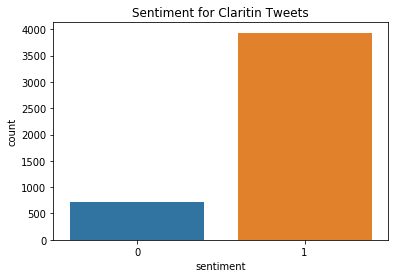

In [120]:
sns.countplot(df['sentiment'])
plt.title('Sentiment for Claritin Tweets')
plt.show()

Above is a breakdown of the variable for the classificaiton task. The variable was created by grouping the tweets with sentiment >= 3 and < 3. This was done because the neutral tweets appeared similar to the positive tweets via inspection. This makes sense from a business  case perspective because it makes the group in which the negative tweets are categorized more homogenous.

* [10 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

For our classification task the team will mainly be concerned with accuracy. A high overall accuracy would give confidence that the classifier can correctly predict both classes making the model useful for the business case described above. As a secondary metric the team will be cognizant of the precision. The classifier's precision will need to be considered because if the model classifies negative tweets incorrectly as positive this would make the action items related to the described business plan incorrect.

* [10 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

## Model Asssessment / Cross-Validation
The team will use stratified shuffle split when cross validating. The stratification will be used to help the model learn since the supervisor is imbalanced. Shuffling will be used because tweets occur linearly. The shuffling will ensure that the train and test split is not dependent on an oustide event that could have changed the tweets over time.

The stratified shuffle split will then be used to perform 5-fold cross validation to provide a better assessment of the performance of our model. To avoid inaccurate estimates of model performance, the weights of the model must be reset at the beginning of each iteration. If we do not do this, it is likely that data the model has previously been trained with will be included in the validation set used to assess performance in that iteration. After each iteration accuracy and precision will be calculated. An LSTM will be compared to GRU rnn via these two metrics with a two sample ttest.

Next, the best model will have it's parameters adjusted to see if there is any improvment. The improvment will be measured the same way as described above.

After selecting the model that performs best the model will be fit to the entire dataset using pretrained as well as model trained embeddings. These two can be compared via the t-test as well. Once this test is complete different architecture i.e. number of layers will be attempted to see if performance is improved.

# Modeling
* [20 points] Investigate at least two different recurrent network architectures (perhaps LSTM and GRU). Be sure to use an embedding layer (pre-trained, from scratch, or both). Adjust hyper-parameters of the networks as needed to improve generalization performance. 

In [121]:
# show example without the FOR loop
from keras.models import Sequential, Input, Model
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.callbacks import EarlyStopping


NUM_CLASSES = 2
top_words = 7832
EMBED_SIZE = 50
rnns = []
input_holder = Input(shape=(X_train.shape[1], ))
input_embed = Embedding(top_words, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN)(input_holder) # number of words in each sequence


x = LSTM(25,dropout=0.2, recurrent_dropout=0.2)(input_embed)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)
rnn_LSTM=Model(inputs=input_holder,outputs=x)
rnn_LSTM.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
rnn_LSTM.save_weights('LSTM_weights.model')
print(rnn_LSTM.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 91)                0         
_________________________________________________________________
embedding_8 (Embedding)      (None, 91, 50)            391600    
_________________________________________________________________
lstm_2 (LSTM)                (None, 25)                7600      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 52        
Total params: 399,252
Trainable params: 399,252
Non-trainable params: 0
_________________________________________________________________
None


In [122]:
input_holder = Input(shape=(X_train.shape[1], ))
input_embed = Embedding(top_words, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN)(input_holder) # number of words in each sequence


x = GRU(25,dropout=0.2, recurrent_dropout=0.2)(input_embed)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)
rnn_GRU=Model(inputs=input_holder,outputs=x)
rnn_GRU.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
rnn_GRU.save_weights('GRU_weights.model')
print(rnn_GRU.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 91)                0         
_________________________________________________________________
embedding_9 (Embedding)      (None, 91, 50)            391600    
_________________________________________________________________
gru_6 (GRU)                  (None, 25)                5700      
_________________________________________________________________
dense_9 (Dense)              (None, 2)                 52        
Total params: 397,352
Trainable params: 397,352
Non-trainable params: 0
_________________________________________________________________
None


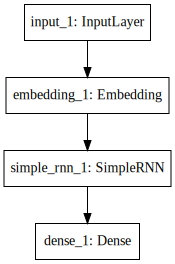

In [123]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# vis
SVG(model_to_dot(rnn).create(prog='dot', format='svg'))

In [124]:
history_LSTM = train_model_cv(rnn_LSTM, X_train, y_train_int, y_train_ohe, X_test, y_test_ohe, folds=10, weights='LSTM_weights.model')

holding fold 1 out
Train on 3356 samples, validate on 374 samples
Epoch 1/30
3356/3356 [==============================] - 9s 3ms/step - loss: 0.4495 - acc: 0.8400 - val_loss: 0.4147 - val_acc: 0.8422
Epoch 2/30
3356/3356 [==============================] - 7s 2ms/step - loss: 0.3639 - acc: 0.8449 - val_loss: 0.3804 - val_acc: 0.8422
Epoch 3/30
3356/3356 [==============================] - 7s 2ms/step - loss: 0.3047 - acc: 0.8643 - val_loss: 0.3770 - val_acc: 0.8596
Epoch 4/30
3356/3356 [==============================] - 7s 2ms/step - loss: 0.2700 - acc: 0.8845 - val_loss: 0.3915 - val_acc: 0.8529
Epoch 5/30
3356/3356 [==============================] - 7s 2ms/step - loss: 0.2331 - acc: 0.9061 - val_loss: 0.4005 - val_acc: 0.8556
Epoch 6/30
3356/3356 [==============================] - 7s 2ms/step - loss: 0.2022 - acc: 0.9252 - val_loss: 0.4205 - val_acc: 0.8503
Epoch 7/30
3356/3356 [==============================] - 7s 2ms/step - loss: 0.1722 - acc: 0.9376 - val_loss: 0.4343 - val_acc: 0.8

3357/3357 [==============================] - 7s 2ms/step - loss: 0.2312 - acc: 0.9068 - val_loss: 0.3124 - val_acc: 0.8606
Epoch 6/30
3357/3357 [==============================] - 7s 2ms/step - loss: 0.2009 - acc: 0.9243 - val_loss: 0.3226 - val_acc: 0.8445
Epoch 7/30
3357/3357 [==============================] - 7s 2ms/step - loss: 0.1714 - acc: 0.9371 - val_loss: 0.3231 - val_acc: 0.8646
Epoch 8/30
3357/3357 [==============================] - 7s 2ms/step - loss: 0.1463 - acc: 0.9456 - val_loss: 0.3287 - val_acc: 0.8606
Epoch 9/30
3357/3357 [==============================] - 7s 2ms/step - loss: 0.1245 - acc: 0.9578 - val_loss: 0.3674 - val_acc: 0.8579
holding fold 9 out
Train on 3358 samples, validate on 372 samples
Epoch 1/30
3358/3358 [==============================] - 8s 2ms/step - loss: 0.5046 - acc: 0.8347 - val_loss: 0.4099 - val_acc: 0.8441
Epoch 2/30
3358/3358 [==============================] - 7s 2ms/step - loss: 0.3785 - acc: 0.8440 - val_loss: 0.3346 - val_acc: 0.8414
Epoch 3

In [125]:
history_GRU = train_model_cv(rnn_GRU, X_train, y_train_int, y_train_ohe, X_test, y_test_ohe, folds=10, weights='GRU_weights.model')

holding fold 1 out
Train on 3356 samples, validate on 374 samples
Epoch 1/30
3356/3356 [==============================] - 7s 2ms/step - loss: 0.4423 - acc: 0.8410 - val_loss: 0.3652 - val_acc: 0.8422
Epoch 2/30
3356/3356 [==============================] - 6s 2ms/step - loss: 0.3430 - acc: 0.8495 - val_loss: 0.3500 - val_acc: 0.8449
Epoch 3/30
3356/3356 [==============================] - 6s 2ms/step - loss: 0.2962 - acc: 0.8746 - val_loss: 0.3360 - val_acc: 0.8356
Epoch 4/30
3356/3356 [==============================] - 6s 2ms/step - loss: 0.2547 - acc: 0.8950 - val_loss: 0.3467 - val_acc: 0.8489
Epoch 5/30
3356/3356 [==============================] - 6s 2ms/step - loss: 0.2197 - acc: 0.9148 - val_loss: 0.3581 - val_acc: 0.8650
Epoch 6/30
3356/3356 [==============================] - 6s 2ms/step - loss: 0.1934 - acc: 0.9258 - val_loss: 0.3685 - val_acc: 0.8610
Epoch 7/30
3356/3356 [==============================] - 6s 2ms/step - loss: 0.1562 - acc: 0.9435 - val_loss: 0.4012 - val_acc: 0.8

Epoch 2/30
3358/3358 [==============================] - 6s 2ms/step - loss: 0.3466 - acc: 0.8454 - val_loss: 0.3598 - val_acc: 0.8616
Epoch 3/30
3358/3358 [==============================] - 6s 2ms/step - loss: 0.2958 - acc: 0.8736 - val_loss: 0.3606 - val_acc: 0.8374
Epoch 4/30
3358/3358 [==============================] - 6s 2ms/step - loss: 0.2527 - acc: 0.9001 - val_loss: 0.3715 - val_acc: 0.8481
Epoch 5/30
3358/3358 [==============================] - 6s 2ms/step - loss: 0.2086 - acc: 0.9205 - val_loss: 0.3988 - val_acc: 0.8441
Epoch 6/30
3358/3358 [==============================] - 6s 2ms/step - loss: 0.1804 - acc: 0.9317 - val_loss: 0.4245 - val_acc: 0.8159
holding fold 10 out
Train on 3358 samples, validate on 372 samples
Epoch 1/30
3358/3358 [==============================] - 6s 2ms/step - loss: 0.4828 - acc: 0.8364 - val_loss: 0.3810 - val_acc: 0.8441
Epoch 2/30
3358/3358 [==============================] - 6s 2ms/step - loss: 0.3469 - acc: 0.8465 - val_loss: 0.3686 - val_acc: 0.

Below is a visualization of the last fit during the cross validation. It appears that dataset is not very predictive.

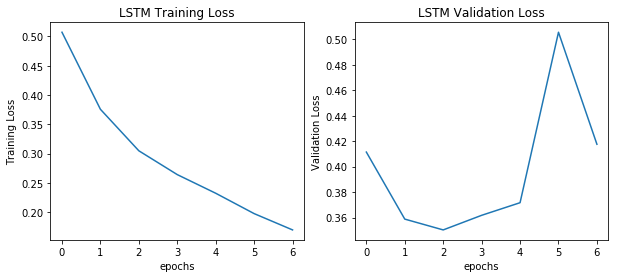

In [126]:
plot_losses(rnn_LSTM, 'LSTM')

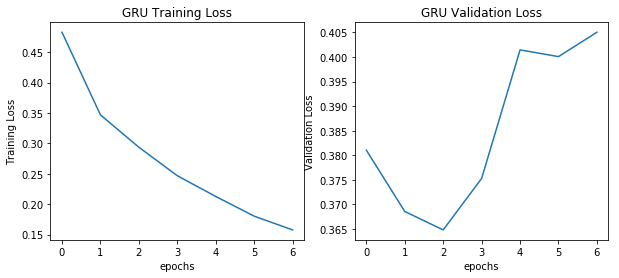

In [127]:
plot_losses(rnn_GRU, 'GRU')

The LSTM model can also be compared to the GRU model via precision and accuracy score

In [128]:
from scipy.stats import ttest_ind

# two sample t test to compare the lstm to the gru
ttest_ind(history_GRU[-2], history_LSTM[-2])

Ttest_indResult(statistic=0.43351474577319554, pvalue=0.6697916770336719)

There appears to be no difference between the two models when compared via accuracy

In [129]:
# two sample t test to compare the lstm to the gru
ttest_ind(history_GRU[-1], history_LSTM[-1])

Ttest_indResult(statistic=-0.8010719787292399, pvalue=0.43353751091250436)

There also appears to be no difference between the two models when compared via precision. The GRU rnn will be compared to another GRU with activation relu, dropout at .1, recurrent dropout at .1, and state vector 150 as opposed to tanh with state vector 25, dropout at .2, and recurrent dropout at .2.

In [130]:
input_holder = Input(shape=(X_train.shape[1], ))
input_embed = Embedding(top_words, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN)(input_holder) # number of words in each sequence


x = GRU(150,dropout=0.1, recurrent_dropout=0.1, activation='relu', kernel_initializer='he_uniform')(input_embed)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)
rnn_GRU_relu=Model(inputs=input_holder,outputs=x)
rnn_GRU_relu.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
rnn_GRU_relu.save_weights('GRU_weights_relu.model')
print(rnn_GRU_relu.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 91)                0         
_________________________________________________________________
embedding_10 (Embedding)     (None, 91, 50)            391600    
_________________________________________________________________
gru_7 (GRU)                  (None, 150)               90450     
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 302       
Total params: 482,352
Trainable params: 482,352
Non-trainable params: 0
_________________________________________________________________
None


In [131]:
history_GRU_relu = train_model_cv(rnn_GRU_relu, X_train, y_train_int, y_train_ohe, X_test, y_test_ohe, folds=10, weights='GRU_weights_relu.model')

holding fold 1 out
Train on 3356 samples, validate on 374 samples
Epoch 1/30
3356/3356 [==============================] - 11s 3ms/step - loss: 2.3955 - acc: 0.8404 - val_loss: 2.5288 - val_acc: 0.8422
Epoch 2/30
3356/3356 [==============================] - 10s 3ms/step - loss: 2.4982 - acc: 0.8442 - val_loss: 2.5288 - val_acc: 0.8422
Epoch 3/30
3356/3356 [==============================] - 10s 3ms/step - loss: 2.4982 - acc: 0.8442 - val_loss: 2.5288 - val_acc: 0.8422
Epoch 4/30
3356/3356 [==============================] - 10s 3ms/step - loss: 2.4982 - acc: 0.8442 - val_loss: 2.5288 - val_acc: 0.8422
Epoch 5/30
3356/3356 [==============================] - 10s 3ms/step - loss: 2.4982 - acc: 0.8442 - val_loss: 2.5288 - val_acc: 0.8422
holding fold 2 out
Train on 3356 samples, validate on 374 samples
Epoch 1/30
3356/3356 [==============================] - 10s 3ms/step - loss: 2.3632 - acc: 0.8409 - val_loss: 2.5288 - val_acc: 0.8422
Epoch 2/30
3356/3356 [==============================] - 10

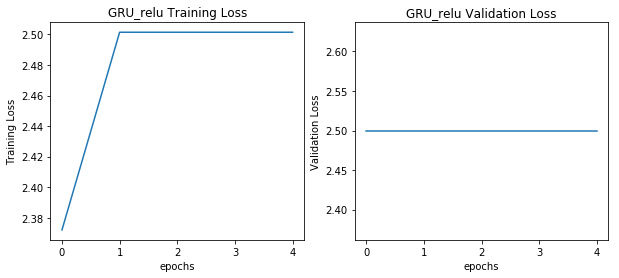

In [132]:
plot_losses(rnn_GRU_relu, 'GRU_relu')

In [133]:
# two sample t test to compare the lstm to the gru
ttest_ind(history_GRU[-2], history_GRU_relu[-2])

Ttest_indResult(statistic=4.959070657526469, pvalue=0.00010144892316175937)

In [134]:
# two sample t test to compare the lstm to the gru
ttest_ind(history_GRU[-1], history_GRU_relu[-1])

Ttest_indResult(statistic=43.59585906091524, pvalue=1.0488447878190767e-19)

Both accuracy and precision were different when comparing the models via two sample ttest. 

In [135]:
# create dataframe for comparing
df=pd.DataFrame([history_GRU[-2], history_GRU_relu[-2]]).T
df.columns = ['GRU','GRU_relu']

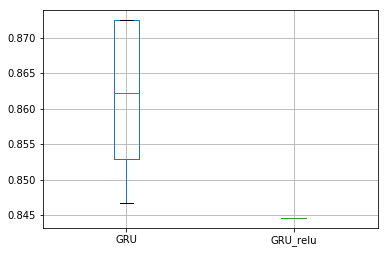

In [136]:
df.boxplot(['GRU','GRU_relu'])

Accuracy compared

In [137]:
# create dataframe for comparing
df=pd.DataFrame([history_GRU[-1], history_GRU_relu[-1]]).T
df.columns = ['GRU','GRU_relu']

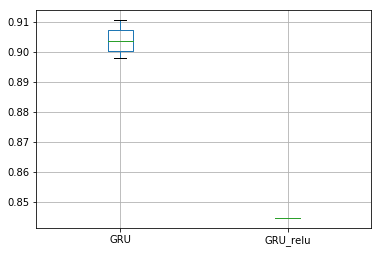

In [138]:
df.boxplot(['GRU','GRU_relu'])

Precision compared

Examining the validation loss curve for both the orginal GRU model created to the GRU with new parameters we find that they perform similarly. When comparing the evaluation metrics precision and accuracy we find that the first GRU model generalizing better. This can be seen in the ttest results as well as the box plot. The new parameters for the GRU do not help with generalization at all.

## Using pretrained embeddings

In [139]:
%%time
EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open(r'C:\Users\MillerV\Documents\Masters Statistics\CSE7324\Embeddings\glove.6B.100d.txt', encoding='utf8')

# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

Found 400000 word vectors.
(7832, 100)
Wall time: 15 s


In [140]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=MAX_ART_LEN,
                            trainable=False)

In [141]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

rnn_GRU_glove = Sequential()
rnn_GRU_glove.add(embedding_layer)
rnn_GRU_glove.add(GRU(25,dropout=0.2, recurrent_dropout=0.2))
rnn_GRU_glove.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn_GRU_glove.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
rnn_GRU_glove.save_weights('GRU_glove_weights.model')
print(rnn_GRU_glove.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 91, 100)           783200    
_________________________________________________________________
gru_8 (GRU)                  (None, 25)                9450      
_________________________________________________________________
dense_11 (Dense)             (None, 2)                 52        
Total params: 792,702
Trainable params: 9,502
Non-trainable params: 783,200
_________________________________________________________________
None


In [142]:
history_GRU_glove = train_model_cv(rnn_GRU_glove, X_train, y_train_int, y_train_ohe, X_test, y_test_ohe, folds=10, weights='GRU_glove_weights.model')

holding fold 1 out
Train on 3356 samples, validate on 374 samples
Epoch 1/30
3356/3356 [==============================] - 6s 2ms/step - loss: 0.4462 - acc: 0.8206 - val_loss: 0.4169 - val_acc: 0.8409
Epoch 2/30
3356/3356 [==============================] - 5s 1ms/step - loss: 0.3840 - acc: 0.8439 - val_loss: 0.4150 - val_acc: 0.8422
Epoch 3/30
3356/3356 [==============================] - 4s 1ms/step - loss: 0.3708 - acc: 0.8465 - val_loss: 0.4043 - val_acc: 0.8302
Epoch 4/30
3356/3356 [==============================] - 5s 1ms/step - loss: 0.3694 - acc: 0.8485 - val_loss: 0.3969 - val_acc: 0.8316
Epoch 5/30
3356/3356 [==============================] - 5s 1ms/step - loss: 0.3637 - acc: 0.8468 - val_loss: 0.3938 - val_acc: 0.8369
Epoch 6/30
3356/3356 [==============================] - 5s 1ms/step - loss: 0.3536 - acc: 0.8516 - val_loss: 0.3890 - val_acc: 0.8316
Epoch 7/30
3356/3356 [==============================] - 5s 1ms/step - loss: 0.3491 - acc: 0.8522 - val_loss: 0.3924 - val_acc: 0.8

3357/3357 [==============================] - 4s 1ms/step - loss: 0.3048 - acc: 0.8725 - val_loss: 0.3586 - val_acc: 0.8418
Epoch 17/30
3357/3357 [==============================] - 4s 1ms/step - loss: 0.3015 - acc: 0.8688 - val_loss: 0.3620 - val_acc: 0.8552
holding fold 4 out
Train on 3357 samples, validate on 373 samples
Epoch 1/30
3357/3357 [==============================] - 4s 1ms/step - loss: 0.4666 - acc: 0.8110 - val_loss: 0.3994 - val_acc: 0.8432
Epoch 2/30
3357/3357 [==============================] - 4s 1ms/step - loss: 0.3886 - acc: 0.8450 - val_loss: 0.3995 - val_acc: 0.8432
Epoch 3/30
3357/3357 [==============================] - 4s 1ms/step - loss: 0.3772 - acc: 0.8469 - val_loss: 0.3843 - val_acc: 0.8405
Epoch 4/30
3357/3357 [==============================] - 5s 1ms/step - loss: 0.3701 - acc: 0.8464 - val_loss: 0.3796 - val_acc: 0.8338
Epoch 5/30
3357/3357 [==============================] - 4s 1ms/step - loss: 0.3625 - acc: 0.8499 - val_loss: 0.3785 - val_acc: 0.8405
Epoch 

3357/3357 [==============================] - 5s 1ms/step - loss: 0.2941 - acc: 0.8771 - val_loss: 0.3610 - val_acc: 0.8485
Epoch 18/30
3357/3357 [==============================] - 5s 1ms/step - loss: 0.2865 - acc: 0.8755 - val_loss: 0.3642 - val_acc: 0.8525
holding fold 7 out
Train on 3357 samples, validate on 373 samples
Epoch 1/30
3357/3357 [==============================] - 4s 1ms/step - loss: 0.4669 - acc: 0.8077 - val_loss: 0.4122 - val_acc: 0.8458
Epoch 2/30
3357/3357 [==============================] - 5s 1ms/step - loss: 0.3901 - acc: 0.8424 - val_loss: 0.3950 - val_acc: 0.8458
Epoch 3/30
3357/3357 [==============================] - 4s 1ms/step - loss: 0.3722 - acc: 0.8452 - val_loss: 0.3876 - val_acc: 0.8525
Epoch 4/30
3357/3357 [==============================] - 5s 1ms/step - loss: 0.3726 - acc: 0.8436 - val_loss: 0.3828 - val_acc: 0.8472
Epoch 5/30
3357/3357 [==============================] - 5s 1ms/step - loss: 0.3670 - acc: 0.8441 - val_loss: 0.3774 - val_acc: 0.8606
Epoch 

3358/3358 [==============================] - 5s 1ms/step - loss: 0.3283 - acc: 0.8614 - val_loss: 0.3152 - val_acc: 0.8616
Epoch 13/30
3358/3358 [==============================] - 5s 1ms/step - loss: 0.3270 - acc: 0.8612 - val_loss: 0.3118 - val_acc: 0.8548
Epoch 14/30
3358/3358 [==============================] - 5s 1ms/step - loss: 0.3213 - acc: 0.8648 - val_loss: 0.3071 - val_acc: 0.8575
Epoch 15/30
3358/3358 [==============================] - 5s 1ms/step - loss: 0.3081 - acc: 0.8666 - val_loss: 0.3050 - val_acc: 0.8562
Epoch 16/30
3358/3358 [==============================] - 5s 1ms/step - loss: 0.3114 - acc: 0.8691 - val_loss: 0.3034 - val_acc: 0.8575
Epoch 17/30
3358/3358 [==============================] - 5s 1ms/step - loss: 0.3023 - acc: 0.8702 - val_loss: 0.3067 - val_acc: 0.8535
Epoch 18/30
3358/3358 [==============================] - 5s 1ms/step - loss: 0.3028 - acc: 0.8722 - val_loss: 0.3050 - val_acc: 0.8589
Epoch 19/30
3358/3358 [==============================] - 4s 1ms/ste

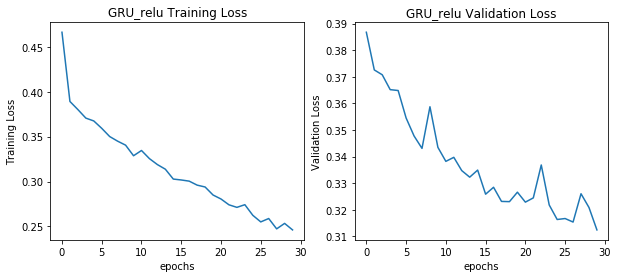

In [143]:
plot_losses(rnn_GRU_glove, 'GRU_relu')

The validation curve decreased acrossed epochs!

In [144]:
# two sample t test to compare the lstm to the gru
ttest_ind(history_GRU[-2], history_GRU_glove[-2])

Ttest_indResult(statistic=2.482440069155482, pvalue=0.023136425968544053)

accuracy compared

In [145]:
# two sample t test to compare the lstm to the gru
ttest_ind(history_GRU[-1], history_GRU_glove[-1])

Ttest_indResult(statistic=14.960806830231306, pvalue=1.3466978955704133e-11)

precision compared

Both accuracy and precision were different when comparing the models via two sample ttest. 

In [146]:
# create dataframe for comparing
df=pd.DataFrame([history_GRU[-2], history_GRU_glove[-2]]).T
df.columns = ['GRU','GRU_glove']

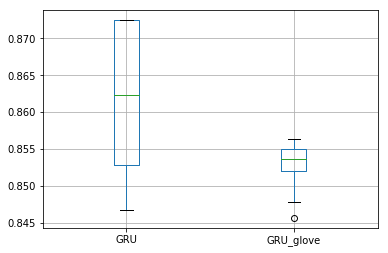

In [147]:
df.boxplot(['GRU','GRU_glove'])

In [148]:
# create dataframe for comparing
df=pd.DataFrame([history_GRU[-1], history_GRU_glove[-1]]).T
df.columns = ['GRU','GRU_glove']

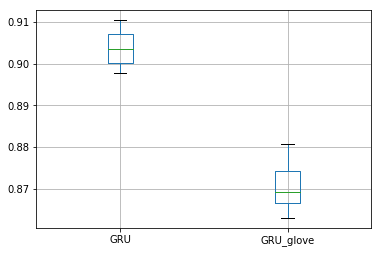

In [149]:
df.boxplot(['GRU','GRU_glove'])

Very intersting to find that the GRU model still outperformed the model using the glove embeddings.

* [20 points] Using the best RNN parameters and architecture, add a second recurrent chain to your RNN. The input to the second chain should be the output sequence of the first chain. Visualize the performance of training and validation sets versus the training iterations. 

## Stacked without pretrain

In [152]:


input_holder = Input(shape=(X_train.shape[1], ))
embed = Embedding(top_words, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN)(input_holder) # number of words in each sequence

x = GRU(25, dropout=0.2, recurrent_dropout=0.2, return_sequences=True)(embed)
x = GRU(25, dropout=0.2, recurrent_dropout=.2)(x)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)
rnn_GRU_2_Layers=Model(inputs=input_holder,outputs=x)
rnn_GRU_2_Layers.compile(loss='binary_crossentropy', 
                  optimizer='rmsprop', 
                  metrics=['accuracy'])
rnn_GRU_2_Layers.save_weights('rnn_GRU_2_Layers.model')
print(rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 91)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 91, 50)            391600    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 25)                1900      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 52        
Total params: 393,552
Trainable params: 393,552
Non-trainable params: 0
_________________________________________________________________
None


In [153]:
history_GRU_2_Layers = train_model_cv(rnn_GRU_2_Layers, X_train, y_train_int, y_train_ohe, X_test, y_test_ohe, folds=10, weights='rnn_GRU_2_Layers.model')

holding fold 1 out
Train on 3356 samples, validate on 374 samples
Epoch 1/30
3356/3356 [==============================] - 13s 4ms/step - loss: 0.4248 - acc: 0.8415 - val_loss: 0.3566 - val_acc: 0.8422
Epoch 2/30
3356/3356 [==============================] - 10s 3ms/step - loss: 0.3248 - acc: 0.8625 - val_loss: 0.3256 - val_acc: 0.8529
Epoch 3/30
3356/3356 [==============================] - 10s 3ms/step - loss: 0.2621 - acc: 0.8966 - val_loss: 0.3227 - val_acc: 0.8503
Epoch 4/30
3356/3356 [==============================] - 10s 3ms/step - loss: 0.2228 - acc: 0.9118 - val_loss: 0.3415 - val_acc: 0.8476
Epoch 5/30
3356/3356 [==============================] - 10s 3ms/step - loss: 0.1788 - acc: 0.9289 - val_loss: 0.3430 - val_acc: 0.8556
Epoch 6/30
3356/3356 [==============================] - 10s 3ms/step - loss: 0.1484 - acc: 0.9431 - val_loss: 0.3708 - val_acc: 0.8650
Epoch 7/30
3356/3356 [==============================] - 11s 3ms/step - loss: 0.1252 - acc: 0.9522 - val_loss: 0.3782 - val_a

Epoch 2/30
3358/3358 [==============================] - 9s 3ms/step - loss: 0.3218 - acc: 0.8626 - val_loss: 0.3509 - val_acc: 0.8522
Epoch 3/30
3358/3358 [==============================] - 10s 3ms/step - loss: 0.2574 - acc: 0.8961 - val_loss: 0.3687 - val_acc: 0.8293
Epoch 4/30
3358/3358 [==============================] - 10s 3ms/step - loss: 0.2075 - acc: 0.9215 - val_loss: 0.4236 - val_acc: 0.8441
Epoch 5/30
3358/3358 [==============================] - 10s 3ms/step - loss: 0.1724 - acc: 0.9328 - val_loss: 0.4310 - val_acc: 0.8441
Epoch 6/30
3358/3358 [==============================] - 12s 4ms/step - loss: 0.1400 - acc: 0.9483 - val_loss: 0.4671 - val_acc: 0.8199


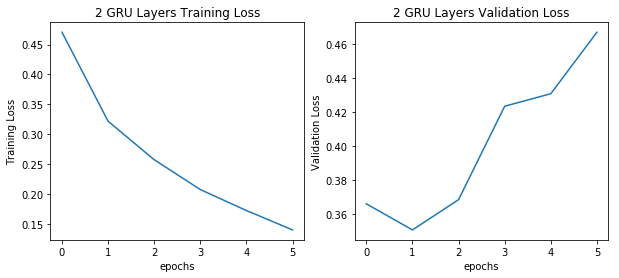

In [154]:
plot_losses(rnn_GRU_2_Layers, '2 GRU Layers')

Training and Validation loss plot for last iteration.

In [156]:
# two sample t test to compare the lstm to the gru
ttest_ind(history_GRU[-2], history_GRU_2_Layers[-2])

Ttest_indResult(statistic=0.599342645653061, pvalue=0.5564138121763389)

Accuracy compared via two sample ttest

In [158]:
# two sample t test to compare the lstm to the gru
ttest_ind(history_GRU[-1], history_GRU_2_Layers[-1])

Ttest_indResult(statistic=1.2159344613691871, pvalue=0.2397164185682384)

Precision compared via two sample ttest

The additional recurrent layer did not add benefit

In [160]:
# create dataframe for comparing
df=pd.DataFrame([history_GRU[-2], history_GRU_2_Layers[-2]]).T
df.columns = ['GRU','GRU_2_layers']

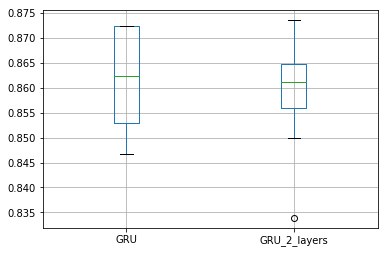

In [162]:
df.boxplot(['GRU','GRU_2_layers'])

accuracy compared

In [163]:
# create dataframe for comparing
df=pd.DataFrame([history_GRU[-1], history_GRU_2_Layers[-1]]).T
df.columns = ['GRU','GRU_2_layers']

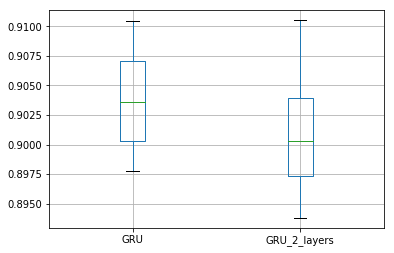

In [164]:
df.boxplot(['GRU','GRU_2_layers'])

precision compared

After attempting to use different recurrent layers, tune parameters, use pretrained embeddings, and adding layers the team was not able to see any improvement in the results. The original GRU architecture will be trained on the entire dataset, and performance will be evaluated.

* [20 points] Use the method of cross validation and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the RNNs you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior.  

Cross validation of this model was already used to find the values for the initial model. These results as well as the results from the comparison models can be seen above. This last fit was performed to discuss the performance of the model.

In [174]:
EMBED_SIZE=50

input_holder = Input(shape=(X_train.shape[1], ))
input_embed = Embedding(top_words, # input dimension (max int of OHE)
                EMBED_SIZE, # output dimension size
                input_length=MAX_ART_LEN)(input_holder) # number of words in each sequence


x = GRU(25,dropout=0.2, recurrent_dropout=0.2)(input_embed)
x = Dense(NUM_CLASSES, activation='sigmoid')(x)
rnn_GRU=Model(inputs=input_holder,outputs=x)
rnn_GRU.compile(loss='binary_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
rnn_GRU.load_weights('GRU_weights.model')
print(rnn_GRU.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 91)                0         
_________________________________________________________________
embedding_15 (Embedding)     (None, 91, 50)            391600    
_________________________________________________________________
gru_13 (GRU)                 (None, 25)                5700      
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 52        
Total params: 397,352
Trainable params: 397,352
Non-trainable params: 0
_________________________________________________________________
None


In [175]:
rnn_GRU.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=3, batch_size=24)

Train on 3730 samples, validate on 933 samples
Epoch 1/3
3730/3730 [==============================] - 11s 3ms/step - loss: 0.4217 - acc: 0.8420 - val_loss: 0.3656 - val_acc: 0.8446
Epoch 2/3
3730/3730 [==============================] - 9s 2ms/step - loss: 0.3370 - acc: 0.8527 - val_loss: 0.3464 - val_acc: 0.8623
Epoch 3/3
3730/3730 [==============================] - 9s 2ms/step - loss: 0.2909 - acc: 0.8777 - val_loss: 0.3340 - val_acc: 0.8676936


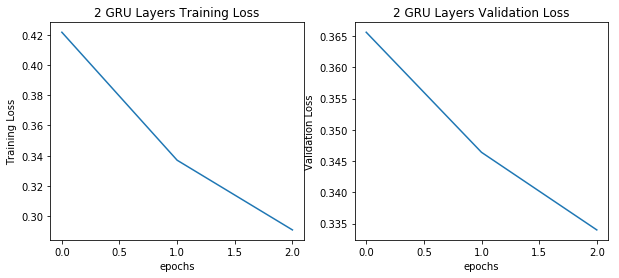

In [176]:
plot_losses(rnn_GRU, '2 GRU Layers')

Three epochs were selected via inspection of the loss curves.

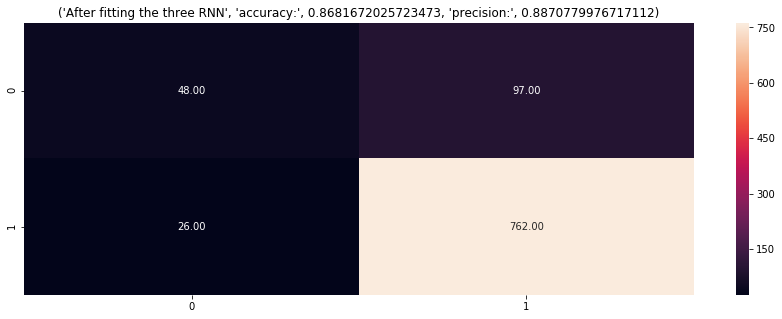

In [177]:
# confusion matrix
summarize_net(rnn_GRU, X_test, y_test_ohe.argmax(1), title_text = 'After fitting the three RNN')

The final model found 93 negative tweets as positive. These results gave a precision of 88%. The overall accuracy of the model was 86.8%. This was ~2% improvement on the prior probability. Given the precision and overall accuracy it does not appear that the model would be viable for the business case described above. Our hypothesis given inspection of the tweets was that the team who assigned the sentiment did not create a predictive dataset. Given the size of the tweets and the inconsistency of the sentiment scores the dataset is not very predictive. Potenitally additional tweets containing the word claritin could improve the model, but this is only if the sentiment scores are applied consistently.